In [89]:
import numpy as np
import matplotlib.pyplot as plt

In [90]:
class FuzzySet:
    def __init__(self, universe, mf):
        self.universe = universe
        self.mf = mf

    def __and__(self, other):
        return FuzzySet(self.universe, np.minimum(self.mf, other.mf))

    def __or__(self, other):
        return FuzzySet(self.universe, np.maximum(self.mf, other.mf))

In [91]:
class FuzzyOperators:
    def __init__(self, terms, operator):
        self.terms = terms
        self.operator = operator

    def __and__(self, other):
        return FuzzyOperators(self.terms + [other], 'and')

    def __or__(self, other):
        return FuzzyOperators(self.terms + [other], 'or')

In [92]:
class Antecedent:
    def __init__(self, universe, label):
        self.universe = universe
        self.label = label
        self.terms = {}

    def __getitem__(self, key):
        return self.terms[key]

    def __setitem__(self, key, value):
        self.terms[key] = FuzzySet(self.universe, value)

    def view(self, sim=None):
        plt.figure(figsize=(10, 4))
        for term, fuzzy_set in self.terms.items():
            plt.plot(self.universe, fuzzy_set.mf, label=term)
            # Check if sim is provided and if input value exists
            if sim and self.label in sim.input:
                input_value = sim.input[self.label]
                membership = fuzzy_set.mf[np.abs(self.universe - input_value).argmin()]
                plt.plot([input_value, input_value], [0, membership], 'k--')
                plt.plot(input_value, membership, 'ko')
                plt.axvline(x=input_value, color='y', linestyle='--', label='Input')
        plt.title(f'Funciones de pertenencia para {self.label.capitalize()}')
        plt.xlabel('Universo')
        plt.ylabel('Pertenencia')
        plt.legend()
        plt.grid(True)
        plt.show()

In [93]:
class Consequent(Antecedent):
    def view(self, sim=None):
        plt.figure(figsize=(10, 4))
        for term, fuzzy_set in self.terms.items():
            plt.plot(self.universe, fuzzy_set.mf, label=term)
        
        if sim and self.label in sim.output:
            output_value = sim.output[self.label]
            plt.axvline(x=output_value, color='r', linestyle='--', label='Output')
            plt.plot(output_value, 0, 'ro')

        plt.title(f'Funciones de pertenencia para {self.label.capitalize()}')
        plt.xlabel('Universo')
        plt.ylabel('Pertenencia')
        plt.legend()
        plt.grid(True)
        plt.show()


# Monkey-patch Antecedent and FuzzySet to add fuzzy operators
Antecedent.__and__ = lambda self, other: FuzzyOperators([self, other], 'and')
Antecedent.__or__ = lambda self, other: FuzzyOperators([self, other], 'or')
FuzzySet.__and__ = lambda self, other: FuzzyOperators([self, other], 'and')
FuzzySet.__or__ = lambda self, other: FuzzyOperators([self, other], 'or')

In [94]:
class Rule:
    def __init__(self, antecedent, consequent):
        self.antecedent = antecedent
        self.consequent = consequent

In [95]:
class ControlSystem:
    def __init__(self, rules):
        self.rules = rules

In [96]:
class ControlSystemSimulation:
    def __init__(self, control_system):
        self.control_system = control_system
        self.input = {}
        self.output = {}

    def compute(self):
        for rule in self.control_system.rules:
            antecedent_value = self.evaluate_antecedent(rule.antecedent)
            consequent_variable = rule.consequent[0]
            consequent_term = rule.consequent[1]
            
            if consequent_variable.label not in self.output:
                self.output[consequent_variable.label] = {}
            
            if consequent_term not in self.output[consequent_variable.label]:
                self.output[consequent_variable.label][consequent_term] = antecedent_value
            else:
                self.output[consequent_variable.label][consequent_term] = max(
                    self.output[consequent_variable.label][consequent_term],
                    antecedent_value
                )

        # Defuzzification
        for label, terms in self.output.items():
            consequent = next(rule.consequent[0] for rule in self.control_system.rules if rule.consequent[0].label == label)
            numerator = 0
            denominator = 0
            for term, strength in terms.items():
                mf = consequent[term].mf
                numerator += np.sum(mf * consequent.universe * strength)
                denominator += np.sum(mf * strength)
            
            self.output[label] = numerator / denominator if denominator != 0 else 0

    def evaluate_antecedent(self, antecedent):
        if isinstance(antecedent, FuzzySet):
            return np.max(antecedent.mf)
        elif isinstance(antecedent, FuzzyOperators):
            if antecedent.operator == 'and':
                return min(self.evaluate_antecedent(term) for term in antecedent.terms)
            elif antecedent.operator == 'or':
                return max(self.evaluate_antecedent(term) for term in antecedent.terms)
        else:
            raise ValueError("Unknown antecedent type")

In [97]:
def trapmf(x, abcd):
    """
    Trapezoidal membership function generator.
    
    Parameters:
        x : array-like
            The input values over which to evaluate the membership function.
        abcd : list
            The parameters that define the trapezoid shape: [a, b, c, d].
    
    Returns:
        numpy.ndarray : Membership values corresponding to each input value in x.
    """
    a, b, c, d = abcd
    y = np.zeros_like(x)

    # Left slope
    mask_left = (a < x) & (x < b)
    if b != a:
        y[mask_left] = (x[mask_left] - a) / (b - a)

    # Flat top
    mask_flat = (b <= x) & (x <= c)
    y[mask_flat] = 1

    # Right slope
    mask_right = (c < x) & (x < d)
    if d != c:
        y[mask_right] = (d - x[mask_right]) / (d - c)
    return y

# universe = np.arange(0, 1001, 0.5)

# result = {
#     "alta": [600, 800, 1000, 1000],
#     "baja": [0, 0, 250, 400]
# }

# plt.figure(figsize=(8, 4))
# for key, item in result.items():

#     mf = trapmf(universe, item)
#     plt.plot(universe, mf, label=key)

# plt.title(f'Funciones de pertenencia para result')
# plt.xlabel('Universo')
# plt.ylabel('Pertenencia')
# plt.legend()
# plt.grid(True)
# plt.show()

In [98]:
def trimf(x, abc):
    """
    Triangular membership function generator.
    """
    a, b, c = abc
    y = np.zeros_like(x)
    
    # Left slope
    mask = (a < x) & (x <= b)
    if b != a:
        y[mask] = (x[mask] - a) / (b - a)
    elif b == a:
        y[x == a] = 1
    
    # Right slope
    mask = (b < x) & (x < c)
    if c != b:
        y[mask] = (c - x[mask]) / (c - b)
    elif c == b:
        y[x == c] = 1
    
    return y

In [99]:
# Antecedentes
universo_velocidad = np.arange(0, 1001, 0.5)
universo_angulo = np.arange(-10, 11, 0.1)

# Consecuentes
universo_posicion = np.arange(0, 11, 1)

In [100]:
velocidad = Antecedent(universo_velocidad, "velocidad")
angulo = Antecedent(universo_angulo, "angulo")
posicion = Consequent(universo_posicion, "posicion")

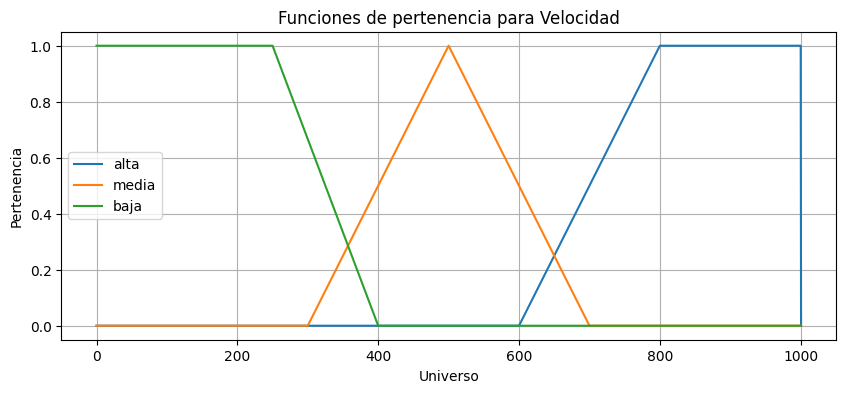

In [101]:
velocidad["alta"] = trapmf(universo_velocidad, [600, 800, 1000, 1000])
velocidad["media"] = trimf(universo_velocidad, [300, 500, 700])
velocidad["baja"] = trapmf(universo_velocidad, [0, 0, 250, 400])
velocidad.view()

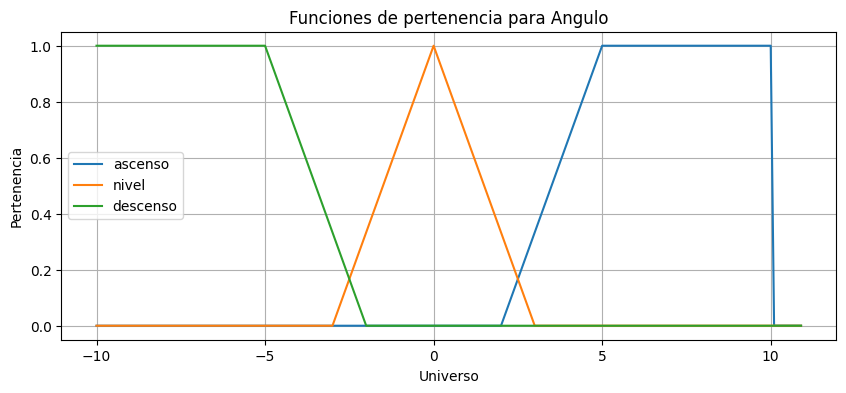

In [102]:
angulo["ascenso"] = trapmf(universo_angulo, [2, 5, 10, 10])
angulo["nivel"] = trimf(universo_angulo, [-3, 0, 3])
angulo["descenso"] = trapmf(universo_angulo, [-10, -10, -5, -2])
angulo.view()

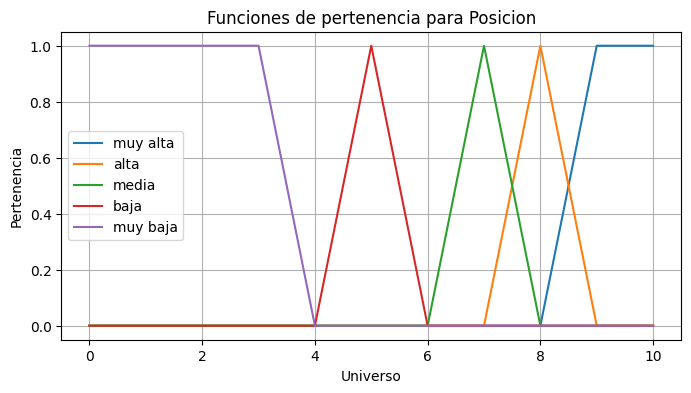

In [103]:
posicion["muy alta"] = trapmf(universo_posicion, [8, 9, 10, 10])
posicion["alta"] = trimf(universo_posicion, [7, 8, 9])
posicion["media"] = trimf(universo_posicion, [6, 7, 8])
posicion["baja"] = trimf(universo_posicion, [4, 5, 6])
posicion["muy baja"] = trapmf(universo_posicion, [0, 0, 3, 4])
posicion.view()

In [104]:
regla_muy_alta = Rule(velocidad["alta"] & angulo["ascenso"], (posicion, "muy alta"))
regla_alta = Rule((velocidad["media"] & angulo["ascenso"]) | (velocidad["alta"] & angulo["nivel"]), (posicion, "alta"))
regla_media = Rule((velocidad["baja"] & angulo["ascenso"]) | (velocidad["media"] & angulo["nivel"]) | (velocidad["baja"] & angulo["descenso"]), (posicion, "media"))
regla_baja = Rule((velocidad["baja"] & angulo["nivel"]) | (velocidad["media"] & angulo["descenso"]), (posicion, "baja"))
regla_muy_baja = Rule(velocidad["alta"] & angulo["descenso"], (posicion, "muy baja"))

In [105]:
control_vuelo = ControlSystem([regla_muy_alta, regla_alta, regla_media, regla_baja, regla_muy_baja])

posicion_timon = ControlSystemSimulation(control_vuelo)
posicion_timon.input["velocidad"] = np.random.randint(0, 100)
posicion_timon.input["angulo"] = np.random.uniform(-10, 10)
posicion_timon.compute()

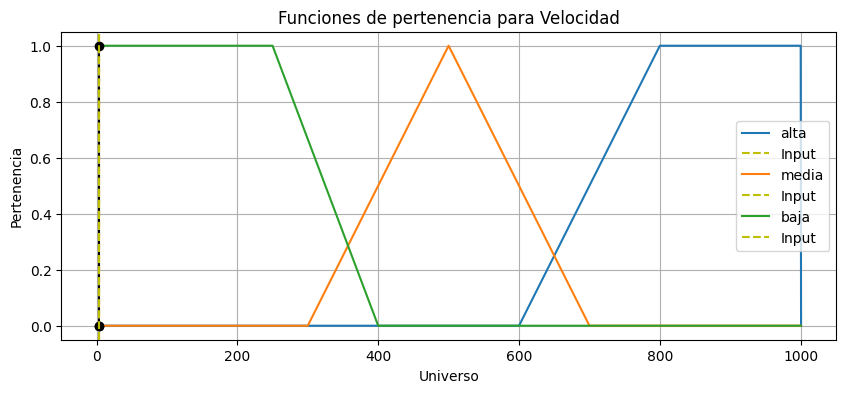

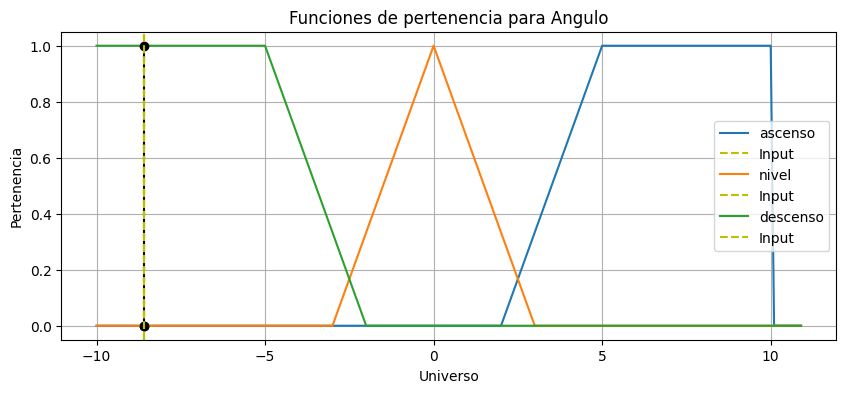

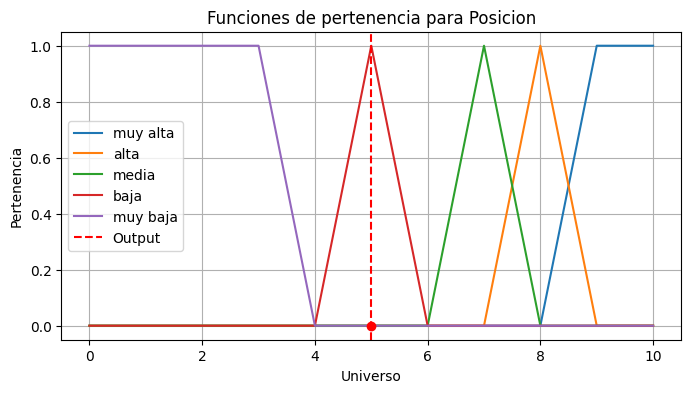

Posición del timón: 5.0


In [106]:
velocidad.view(sim=posicion_timon)
angulo.view(sim=posicion_timon)
posicion.view(sim=posicion_timon)

print(f"Posición del timón: {posicion_timon.output['posicion']}")

In [107]:
print(f"Input Velocidad: {posicion_timon.input['velocidad']}")
print(f"Input Angulo: {posicion_timon.input['angulo']}")
print(f"Output Position: {posicion_timon.output}")

Input Velocidad: 4
Input Angulo: -8.592508271278021
Output Position: {'posicion': 5.0}


In [108]:
print("Membership Functions for Velocidad:")
for term, fuzzy_set in velocidad.terms.items():
    print(f"{term}: {fuzzy_set.mf}")

Membership Functions for Velocidad:
alta: [0. 0. 0. ... 1. 1. 0.]
media: [0. 0. 0. ... 0. 0. 0.]
baja: [1. 1. 1. ... 0. 0. 0.]
